<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/VI_DAMM_0903.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  # mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  truth_theta = {
    'log_mu': np.log(mu),
    'log_sigma': np.log(sigma),
    'log_psi': np.log(psi),
    'log_omega': np.log(omega),
    "log_lambda0": np.log(lambda0_arr),
    'log_pi': np.log(pi_arr),
    'log_tau': np.log(tau_arr)
  }

  return xxx[:,:n_features], xxx[:,n_features], xxx, truth_theta

  #return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(Y.shape[0], 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(s_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

In [4]:
class BasicForwardNet(nn.Module):
  """Encoder for when data is input without any encoding"""
  def __init__(self, input_dim, output_dim, hidden_dim = 5):
    super().__init__()
    
    self.input = nn.Linear(input_dim, hidden_dim)
    self.linear1 = nn.Linear(hidden_dim, hidden_dim)
    self.output = nn.Linear(hidden_dim, output_dim)
    
  def forward(self, x):
    out = F.relu(self.input(x))
    out = F.relu(self.linear1(out))
    out = self.output(out)
        
    return F.softmax(out, dim=1), F.log_softmax(out, dim=1) ## r/v/d log_r/log_v/log_d

In [5]:
def compute_joint_probs(Theta, Y, S):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])
  
  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rzd0 = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_vgd1 = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]

  #remove_indices = np.tril_indices(nc, -1) ## remove indices
  #log_rd1g[:, remove_indices[0], remove_indices[1]] = float("NaN")

  #q1 = r.exp() * log_rd0z #; q1[torch.isnan(q1)] = 0.0
  #q2 = v.exp() * log_rd1g #; q2[torch.isnan(q2)] = 0.0

  return log_rzd0, log_vgd1.reshape(Y.shape[0], nc*nc)

In [6]:
nc = 3; no = 1000; nf = 2

Y, S, XX, theta_true = generateData(n_clusters = nc, n_obs = no, n_features = nf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


In [7]:
np.exp(theta_true['log_pi'])

array([0.12242687, 0.24269658, 0.63487654])

In [8]:
nt = 20
N_ITER = 100000
lr = 1e-3
tol = 1e-6
N_INIT = 20
P = Y.shape[1] + 1

In [9]:
%%capture
!pip install wandb --upgrade

import wandb
wandb.login()

wandb: Paste an API key from your profile and hit enter: ··········


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
wandb: Currently logged in as: yujulee (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 64856.27271547647; pi: tensor([0.3021, 0.4391, 0.2587], dtype=torch.float64)
NELBO: 5078.008076222282; pi: tensor([0.6872, 0.2099, 0.1029], dtype=torch.float64)
NELBO: 2992.1605505187554; pi: tensor([0.8708, 0.0866, 0.0426], dtype=torch.float64)
NELBO: 2530.984922693461; pi: tensor([0.9363, 0.0427, 0.0211], dtype=torch.float64)
NELBO: 2420.1780274618714; pi: tensor([0.9650, 0.0234, 0.0116], dtype=torch.float64)
NELBO: 2390.9958039084595; pi: tensor([0.9796, 0.0136, 0.0068], dtype=torch.float64)
NELBO: 2379.0859238137164; pi: tensor([0.9877, 0.0082, 0.0041], dtype=torch.float64)
NELBO: 2372.2837201979055; pi: tensor([0.9925, 0.0050, 0.0025], dtype=torch.float64)
NELBO: 2368.1862519121332; pi: tensor([0.9953, 0.0031, 0.0016], dtype=torch.float64)
NELBO: 2365.6726661242246; pi: tensor([9.9706e-01, 1.9559e-03, 9.8147e-04], dtype=torch.float64)
NELBO: 2364.1113944528697; pi: tensor([9.9815e-01, 1.2297e-03, 6.1820e-04], dtype=torch.float64)
NELBO: 2363.1345698176447; pi: tensor([9.988

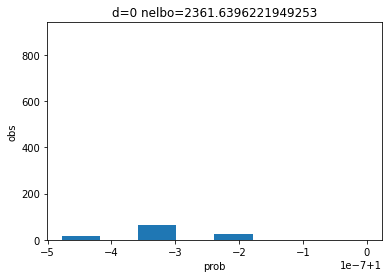

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,15932
nelbo,2361.63962
entropy,-2197.22559
reconstruction_loss,-4558.86521
_runtime,217
_timestamp,1630670482
_step,15931


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▆▇▇████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 58135.97183699036; pi: tensor([0.4382, 0.3027, 0.2592], dtype=torch.float64)
NELBO: 10096.258997632696; pi: tensor([0.3963, 0.3066, 0.2971], dtype=torch.float64)
NELBO: 5273.686286341008; pi: tensor([0.3850, 0.3063, 0.3087], dtype=torch.float64)
NELBO: 4027.3803686125884; pi: tensor([0.3771, 0.3069, 0.3159], dtype=torch.float64)
NELBO: 3646.370963390754; pi: tensor([0.3704, 0.3081, 0.3215], dtype=torch.float64)
NELBO: 3532.194172137306; pi: tensor([0.3642, 0.3099, 0.3259], dtype=torch.float64)
NELBO: 3497.4762052828155; pi: tensor([0.3583, 0.3125, 0.3292], dtype=torch.float64)
NELBO: 3482.650759944114; pi: tensor([0.3529, 0.3157, 0.3313], dtype=torch.float64)
NELBO: 3474.041504080138; pi: tensor([0.3482, 0.3193, 0.3325], dtype=torch.float64)
NELBO: 3468.78249332789; pi: tensor([0.3440, 0.3230, 0.3330], dtype=torch.float64)
NELBO: 3465.533865032192; pi: tensor([0.3405, 0.3263, 0.3332], dtype=torch.float64)
NELBO: 3463.507629235195; pi: tensor([0.3377, 0.3290, 0.3333], dtype=torch

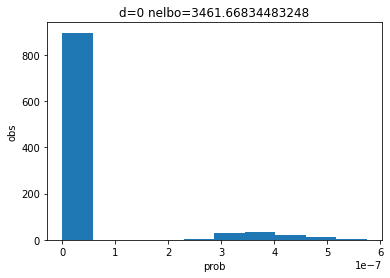

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12650
nelbo,3461.66834
entropy,-1099.05017
reconstruction_loss,-4560.71852
_runtime,175
_timestamp,1630670662
_step,12649


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▆▇▇████████████████████████████████████
reconstruction_loss,▁▄▅▆▇▇▇█████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 78387.06641086064; pi: tensor([0.4382, 0.3027, 0.2592], dtype=torch.float64)
NELBO: 6097.305751018118; pi: tensor([0.0959, 0.7730, 0.1312], dtype=torch.float64)
NELBO: 3724.1253491155303; pi: tensor([0.0398, 0.8992, 0.0610], dtype=torch.float64)
NELBO: 2388.2081935972315; pi: tensor([0.0190, 0.9550, 0.0259], dtype=torch.float64)
NELBO: 1565.260558195796; pi: tensor([0.0104, 0.9764, 0.0131], dtype=torch.float64)
NELBO: 159.05774692228943; pi: tensor([0.0061, 0.9866, 0.0074], dtype=torch.float64)
NELBO: -694.2735747783044; pi: tensor([0.0037, 0.9920, 0.0043], dtype=torch.float64)
NELBO: -1046.4990488248613; pi: tensor([0.0023, 0.9951, 0.0026], dtype=torch.float64)
NELBO: -1141.6552285603225; pi: tensor([0.0014, 0.9970, 0.0016], dtype=torch.float64)
NELBO: -1180.1951896989378; pi: tensor([8.9688e-04, 9.9809e-01, 1.0123e-03], dtype=torch.float64)
NELBO: -1206.0686737568863; pi: tensor([5.6631e-04, 9.9880e-01, 6.3512e-04], dtype=torch.float64)
NELBO: -1224.615155052486; pi: tensor([3

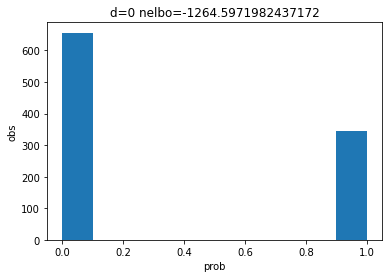

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,20484
nelbo,-1264.5972
entropy,-1697.84924
reconstruction_loss,-433.25204
_runtime,281
_timestamp,1630670948
_step,20483


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
nelbo,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▇█▇▆▅▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▆▇▇▇▇▇▇▇███████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 76634.35210440398; pi: tensor([0.4391, 0.3021, 0.2587], dtype=torch.float64)
NELBO: 7611.847327691297; pi: tensor([0.4707, 0.2859, 0.2434], dtype=torch.float64)
NELBO: 4500.356929441049; pi: tensor([0.4692, 0.2865, 0.2444], dtype=torch.float64)
NELBO: 3785.595665694129; pi: tensor([0.4677, 0.2871, 0.2453], dtype=torch.float64)
NELBO: 3585.5974236719485; pi: tensor([0.4662, 0.2876, 0.2461], dtype=torch.float64)
NELBO: 3520.8550718759598; pi: tensor([0.4648, 0.2882, 0.2470], dtype=torch.float64)
NELBO: 3432.7838711120285; pi: tensor([0.4634, 0.2887, 0.2479], dtype=torch.float64)
NELBO: 1965.1712195090895; pi: tensor([0.4621, 0.2892, 0.2487], dtype=torch.float64)
NELBO: 1521.0987909496998; pi: tensor([0.4607, 0.2898, 0.2495], dtype=torch.float64)
NELBO: 171.75111097949116; pi: tensor([0.4594, 0.2903, 0.2503], dtype=torch.float64)
NELBO: -581.4493002746785; pi: tensor([0.4581, 0.2908, 0.2511], dtype=torch.float64)
NELBO: -674.6476920078962; pi: tensor([0.4568, 0.2913, 0.2519], dtype

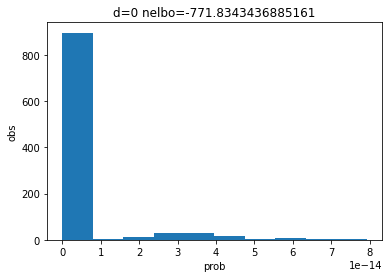

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,18201
nelbo,-771.83434
entropy,-1737.03198
reconstruction_loss,-965.19764
_runtime,252
_timestamp,1630671205
_step,18200


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▆█▆▆▆▆▆▆▆▆▆▆▅▅▃▃▃▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 134611.34852723125; pi: tensor([0.4384, 0.3022, 0.2594], dtype=torch.float64)
NELBO: 10191.487057248516; pi: tensor([0.3813, 0.4335, 0.1852], dtype=torch.float64)
NELBO: 6019.889048413364; pi: tensor([0.3335, 0.5565, 0.1100], dtype=torch.float64)
NELBO: 4900.149331323728; pi: tensor([0.3421, 0.5796, 0.0783], dtype=torch.float64)
NELBO: 4383.537881258384; pi: tensor([0.4301, 0.5060, 0.0639], dtype=torch.float64)
NELBO: 4081.095953843437; pi: tensor([0.5100, 0.4323, 0.0576], dtype=torch.float64)
NELBO: 3863.8075093052303; pi: tensor([0.5081, 0.4275, 0.0644], dtype=torch.float64)
NELBO: 3646.25925824718; pi: tensor([0.4600, 0.4285, 0.1115], dtype=torch.float64)
NELBO: 3540.958873559699; pi: tensor([0.3941, 0.3732, 0.2327], dtype=torch.float64)
NELBO: 3505.2015612286204; pi: tensor([0.3558, 0.3352, 0.3090], dtype=torch.float64)
NELBO: 3487.0022435735036; pi: tensor([0.3429, 0.3278, 0.3293], dtype=torch.float64)
NELBO: 3476.6248469908287; pi: tensor([0.3383, 0.3282, 0.3335], dtype=to

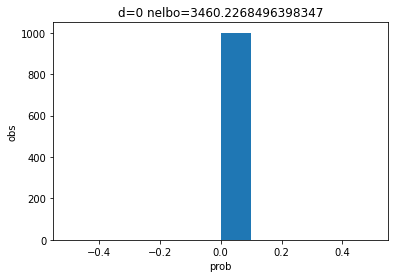

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,21279
nelbo,3460.22685
entropy,-1098.94971
reconstruction_loss,-4559.17656
_runtime,290
_timestamp,1630671499
_step,21278


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂▁▂▃▄▅▆▆▇████▇▇▇▇███████████████████████
reconstruction_loss,▁▅▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 103907.24547816243; pi: tensor([0.4391, 0.2587, 0.3021], dtype=torch.float64)
NELBO: 1669.8390595213905; pi: tensor([0.6610, 0.1016, 0.2374], dtype=torch.float64)
NELBO: 860.6805266367492; pi: tensor([0.6318, 0.0492, 0.3190], dtype=torch.float64)
NELBO: 679.2632426887321; pi: tensor([0.6411, 0.0263, 0.3326], dtype=torch.float64)
NELBO: 598.7551013712246; pi: tensor([0.6473, 0.0151, 0.3375], dtype=torch.float64)
NELBO: 570.2175732166306; pi: tensor([0.6508, 0.0091, 0.3401], dtype=torch.float64)
NELBO: 561.7908839247666; pi: tensor([0.6528, 0.0056, 0.3416], dtype=torch.float64)
NELBO: 558.0350213810025; pi: tensor([0.6540, 0.0035, 0.3425], dtype=torch.float64)
NELBO: 555.5539697086065; pi: tensor([0.6547, 0.0022, 0.3431], dtype=torch.float64)
NELBO: 554.0327659935297; pi: tensor([0.6552, 0.0014, 0.3434], dtype=torch.float64)
NELBO: 553.0854923143652; pi: tensor([0.6555, 0.0009, 0.3436], dtype=torch.float64)
NELBO: 552.5104273995435; pi: tensor([6.5568e-01, 5.5548e-04, 3.4377e-01],

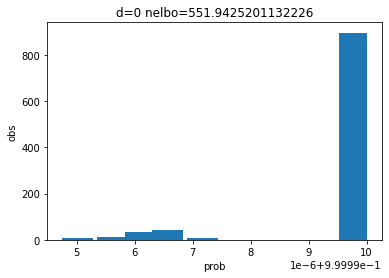

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12904
nelbo,551.94252
entropy,-2197.24219
reconstruction_loss,-2749.18471
_runtime,177
_timestamp,1630671680
_step,12903


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▄██████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 111732.84361337966; pi: tensor([0.4384, 0.3028, 0.2588], dtype=torch.float64)
NELBO: 7818.673483956945; pi: tensor([0.2175, 0.6550, 0.1275], dtype=torch.float64)
NELBO: 3619.16846067796; pi: tensor([0.1138, 0.8192, 0.0669], dtype=torch.float64)
NELBO: 3102.7977867467357; pi: tensor([0.0612, 0.9025, 0.0363], dtype=torch.float64)
NELBO: 2621.015758530726; pi: tensor([0.0464, 0.8850, 0.0687], dtype=torch.float64)
NELBO: 2016.0896915142862; pi: tensor([0.0400, 0.6737, 0.2863], dtype=torch.float64)
NELBO: 1841.706420669425; pi: tensor([0.0240, 0.5501, 0.4258], dtype=torch.float64)
NELBO: 1757.907683883538; pi: tensor([0.0143, 0.4371, 0.5486], dtype=torch.float64)
NELBO: 1699.43994398617; pi: tensor([0.0086, 0.3587, 0.6327], dtype=torch.float64)
NELBO: 1570.1459452944523; pi: tensor([0.0036, 0.0789, 0.9175], dtype=torch.float64)
NELBO: 1558.5912529678699; pi: tensor([0.0019, 0.0305, 0.9676], dtype=torch.float64)
NELBO: 1556.8436412013243; pi: tensor([0.0013, 0.0206, 0.9781], dtype=tor

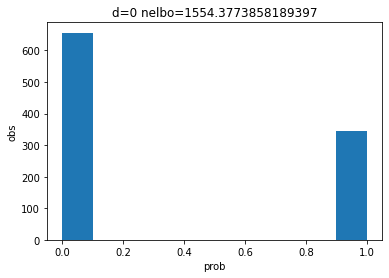

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,15653
nelbo,1554.37739
entropy,-1686.16162
reconstruction_loss,-3240.53901
_runtime,219
_timestamp,1630671904
_step,15652


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▃▄▅█████▇▅▂▂▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
reconstruction_loss,▁▅▇▇████████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 120306.66179384173; pi: tensor([0.2587, 0.4391, 0.3021], dtype=torch.float64)
NELBO: 9947.781347439137; pi: tensor([0.2581, 0.4442, 0.2977], dtype=torch.float64)
NELBO: 5211.523521776451; pi: tensor([0.2620, 0.4386, 0.2994], dtype=torch.float64)
NELBO: 3979.0180988394422; pi: tensor([0.2643, 0.4352, 0.3005], dtype=torch.float64)
NELBO: 3626.710739572757; pi: tensor([0.2665, 0.4321, 0.3015], dtype=torch.float64)
NELBO: 3530.3117228805004; pi: tensor([0.2687, 0.4288, 0.3025], dtype=torch.float64)
NELBO: 3497.4407132798033; pi: tensor([0.2712, 0.4252, 0.3036], dtype=torch.float64)
NELBO: 3482.9749390579054; pi: tensor([0.2743, 0.4208, 0.3049], dtype=torch.float64)
NELBO: 3474.2863412629276; pi: tensor([0.2780, 0.4156, 0.3065], dtype=torch.float64)
NELBO: 3468.9573227903647; pi: tensor([0.2824, 0.4093, 0.3083], dtype=torch.float64)
NELBO: 3465.65198210344; pi: tensor([0.2876, 0.4020, 0.3104], dtype=torch.float64)
NELBO: 3463.5875354740465; pi: tensor([0.2937, 0.3935, 0.3128], dtype=

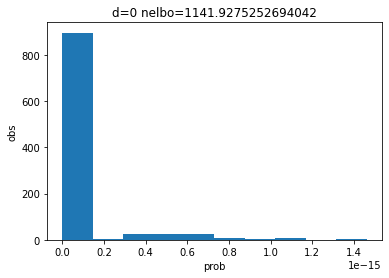

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,25328
nelbo,1141.92753
entropy,-1178.59631
reconstruction_loss,-2320.52384
_runtime,348
_timestamp,1630672257
_step,25327


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
entropy,▇████████▇▇▇▇▇▇▇▇████████▅▁▄▃▄▄▄▄▄▄▄▄▄▄▄
reconstruction_loss,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 64490.05251747796; pi: tensor([0.2587, 0.4391, 0.3021], dtype=torch.float64)
NELBO: 7051.379707348882; pi: tensor([0.1066, 0.2008, 0.6926], dtype=torch.float64)
NELBO: 3491.940992736794; pi: tensor([0.0400, 0.0743, 0.8858], dtype=torch.float64)
NELBO: 2689.3724870054093; pi: tensor([0.0187, 0.0346, 0.9466], dtype=torch.float64)
NELBO: 2487.132037165329; pi: tensor([0.0101, 0.0185, 0.9714], dtype=torch.float64)
NELBO: 2424.550929330131; pi: tensor([0.0058, 0.0106, 0.9836], dtype=torch.float64)
NELBO: 2398.3039946134722; pi: tensor([0.0035, 0.0064, 0.9902], dtype=torch.float64)
NELBO: 2383.8630611465787; pi: tensor([0.0021, 0.0039, 0.9940], dtype=torch.float64)
NELBO: 2375.308340474642; pi: tensor([0.0013, 0.0024, 0.9963], dtype=torch.float64)
NELBO: 2370.115098136853; pi: tensor([8.3143e-04, 1.5090e-03, 9.9766e-01], dtype=torch.float64)
NELBO: 2366.906618997845; pi: tensor([5.2329e-04, 9.4813e-04, 9.9853e-01], dtype=torch.float64)
NELBO: 2364.9016463496528; pi: tensor([3.3035e-04

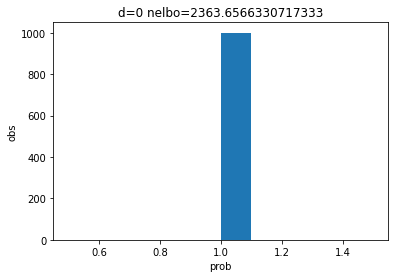

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11974
nelbo,2363.65663
entropy,-2200.61914
reconstruction_loss,-4564.27577
_runtime,164
_timestamp,1630672427
_step,11973


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▂█▇▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▅▆▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 60726.001295581475; pi: tensor([0.3020, 0.4389, 0.2591], dtype=torch.float64)
NELBO: 6261.954125896618; pi: tensor([0.7932, 0.0907, 0.1161], dtype=torch.float64)
NELBO: 4201.62648589492; pi: tensor([0.9227, 0.0339, 0.0434], dtype=torch.float64)
NELBO: 3022.028709039128; pi: tensor([0.8985, 0.0256, 0.0759], dtype=torch.float64)
NELBO: 2201.1370776176445; pi: tensor([0.5796, 0.0230, 0.3974], dtype=torch.float64)
NELBO: 1396.2032836985795; pi: tensor([0.3093, 0.0125, 0.6782], dtype=torch.float64)
NELBO: 897.8733091706808; pi: tensor([0.3029, 0.0076, 0.6895], dtype=torch.float64)
NELBO: -40.43465663923325; pi: tensor([0.3017, 0.0048, 0.6935], dtype=torch.float64)
NELBO: -695.5664965357588; pi: tensor([0.3017, 0.0031, 0.6952], dtype=torch.float64)
NELBO: -880.4061724134974; pi: tensor([0.3018, 0.0020, 0.6962], dtype=torch.float64)
NELBO: -934.6027124454228; pi: tensor([0.3019, 0.0013, 0.6968], dtype=torch.float64)
NELBO: -968.1768208013343; pi: tensor([0.3020, 0.0008, 0.6972], dtype=

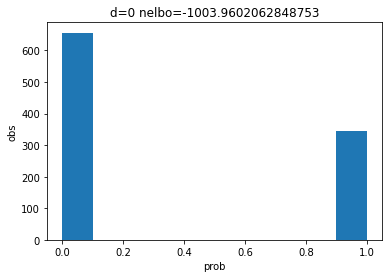

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,19182
nelbo,-1003.96021
entropy,-1522.32593
reconstruction_loss,-518.36572
_runtime,262
_timestamp,1630672694
_step,19181


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▄▇████▄▄▃▃▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▅▆▇▇▇▇▇▇▇▇▇▇███████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 73265.47885619901; pi: tensor([0.4391, 0.3021, 0.2587], dtype=torch.float64)
NELBO: 6624.40615954826; pi: tensor([0.4332, 0.3054, 0.2615], dtype=torch.float64)
NELBO: 4276.948034335946; pi: tensor([0.4293, 0.3067, 0.2640], dtype=torch.float64)
NELBO: 3739.32634918845; pi: tensor([0.4266, 0.3076, 0.2659], dtype=torch.float64)
NELBO: 3587.390019333405; pi: tensor([0.4241, 0.3083, 0.2676], dtype=torch.float64)
NELBO: 3530.2598394309343; pi: tensor([0.4218, 0.3090, 0.2692], dtype=torch.float64)
NELBO: 3501.482755769428; pi: tensor([0.4195, 0.3097, 0.2708], dtype=torch.float64)
NELBO: 3485.1340186544558; pi: tensor([0.4172, 0.3104, 0.2724], dtype=torch.float64)
NELBO: 3475.4622925994418; pi: tensor([0.4150, 0.3110, 0.2740], dtype=torch.float64)
NELBO: 3468.8436738885102; pi: tensor([0.4126, 0.3117, 0.2757], dtype=torch.float64)
NELBO: 3464.85577017412; pi: tensor([0.4095, 0.3126, 0.2779], dtype=torch.float64)
NELBO: 3463.0624148921834; pi: tensor([0.4055, 0.3137, 0.2808], dtype=torch

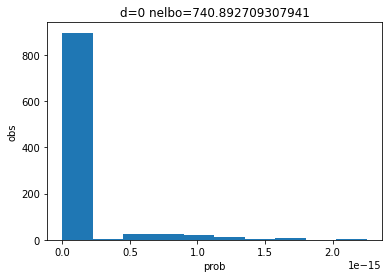

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,22442
nelbo,740.89271
entropy,-1199.85449
reconstruction_loss,-1940.7472
_runtime,304
_timestamp,1630673003
_step,22441


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁█████████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
reconstruction_loss,▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 115521.62244060141; pi: tensor([0.4384, 0.3022, 0.2594], dtype=torch.float64)
NELBO: 10109.204304903691; pi: tensor([0.4229, 0.3070, 0.2701], dtype=torch.float64)
NELBO: 5258.741202980455; pi: tensor([0.4149, 0.3113, 0.2739], dtype=torch.float64)
NELBO: 3994.4048418476723; pi: tensor([0.4086, 0.3142, 0.2771], dtype=torch.float64)
NELBO: 3621.090151506618; pi: tensor([0.4029, 0.3168, 0.2803], dtype=torch.float64)
NELBO: 3519.7115448231634; pi: tensor([0.3972, 0.3193, 0.2835], dtype=torch.float64)
NELBO: 3491.456851562678; pi: tensor([0.3912, 0.3218, 0.2870], dtype=torch.float64)
NELBO: 3479.087604350978; pi: tensor([0.3848, 0.3244, 0.2908], dtype=torch.float64)
NELBO: 3471.502365476539; pi: tensor([0.3780, 0.3270, 0.2951], dtype=torch.float64)
NELBO: 3467.20510477055; pi: tensor([0.3708, 0.3294, 0.2998], dtype=torch.float64)
NELBO: 3382.1114669129383; pi: tensor([0.3636, 0.3316, 0.3048], dtype=torch.float64)
NELBO: 2811.2886703327185; pi: tensor([0.3618, 0.3321, 0.3061], dtype=to

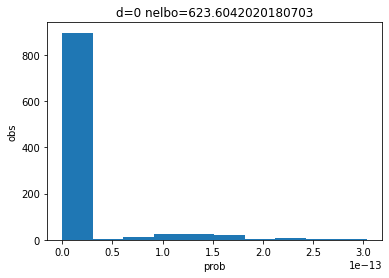

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,31494
nelbo,623.6042
entropy,-1539.96021
reconstruction_loss,-2163.56441
_runtime,443
_timestamp,1630673450
_step,31493


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▇███████████████████████
reconstruction_loss,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 139106.88356906114; pi: tensor([0.4384, 0.3022, 0.2594], dtype=torch.float64)
NELBO: 9690.186780351392; pi: tensor([0.1723, 0.7059, 0.1219], dtype=torch.float64)
NELBO: 5570.2741206108; pi: tensor([0.0590, 0.8989, 0.0422], dtype=torch.float64)
NELBO: 3783.61243219838; pi: tensor([0.0233, 0.9599, 0.0168], dtype=torch.float64)
NELBO: 3289.504885263862; pi: tensor([0.0108, 0.9813, 0.0078], dtype=torch.float64)
NELBO: 3000.8232810648387; pi: tensor([0.0059, 0.9899, 0.0042], dtype=torch.float64)
NELBO: 2390.026778186967; pi: tensor([0.0034, 0.9941, 0.0025], dtype=torch.float64)
NELBO: 2373.870371134546; pi: tensor([0.0021, 0.9964, 0.0015], dtype=torch.float64)
NELBO: 2368.3313429264326; pi: tensor([1.2703e-03, 9.9781e-01, 9.2161e-04], dtype=torch.float64)
NELBO: 2365.530084486464; pi: tensor([7.9273e-04, 9.9863e-01, 5.7583e-04], dtype=torch.float64)
NELBO: 2363.934334002721; pi: tensor([4.9796e-04, 9.9914e-01, 3.6212e-04], dtype=torch.float64)
NELBO: 2362.978110265103; pi: tensor([3.

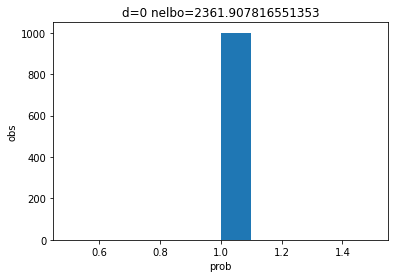

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,13580
nelbo,2361.90782
entropy,-2197.3208
reconstruction_loss,-4559.22862
_runtime,187
_timestamp,1630673643
_step,13579


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▅▅▅▅▅▄▃▃▄▄▄▄▄▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▄▆▇▇▇▇█████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 112176.05702377598; pi: tensor([0.4384, 0.3028, 0.2588], dtype=torch.float64)
NELBO: 7985.392912614747; pi: tensor([0.1683, 0.7310, 0.1006], dtype=torch.float64)
NELBO: 4092.3054910765213; pi: tensor([0.0716, 0.8855, 0.0429], dtype=torch.float64)
NELBO: 2917.158415123332; pi: tensor([0.0358, 0.9426, 0.0216], dtype=torch.float64)
NELBO: 2529.6141112294326; pi: tensor([0.0198, 0.9683, 0.0119], dtype=torch.float64)
NELBO: 2411.1888884445425; pi: tensor([0.0116, 0.9814, 0.0070], dtype=torch.float64)
NELBO: 2380.163942166075; pi: tensor([0.0070, 0.9888, 0.0042], dtype=torch.float64)
NELBO: 2371.797359712108; pi: tensor([0.0043, 0.9931, 0.0026], dtype=torch.float64)
NELBO: 2367.885693275487; pi: tensor([0.0027, 0.9957, 0.0016], dtype=torch.float64)
NELBO: 2365.4508603199056; pi: tensor([0.0017, 0.9973, 0.0010], dtype=torch.float64)
NELBO: 2363.9491825520627; pi: tensor([1.0523e-03, 9.9831e-01, 6.4215e-04], dtype=torch.float64)
NELBO: 2363.0263920937705; pi: tensor([6.6378e-04, 9.9893e

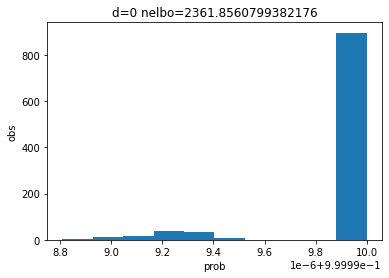

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,14011
nelbo,2361.85608
entropy,-2197.22754
reconstruction_loss,-4559.08362
_runtime,193
_timestamp,1630673841
_step,14010


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▅▆▇▇███████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 93881.08897430733; pi: tensor([0.2594, 0.4384, 0.3022], dtype=torch.float64)
NELBO: 6681.373301318512; pi: tensor([0.2402, 0.1908, 0.5690], dtype=torch.float64)
NELBO: 3673.6445227997237; pi: tensor([0.3970, 0.0610, 0.5421], dtype=torch.float64)
NELBO: 2979.634102541604; pi: tensor([0.6233, 0.0294, 0.3473], dtype=torch.float64)
NELBO: 2433.9867863822606; pi: tensor([0.9078, 0.0114, 0.0807], dtype=torch.float64)
NELBO: 2334.148007805707; pi: tensor([0.9652, 0.0057, 0.0292], dtype=torch.float64)
NELBO: 2270.712393110367; pi: tensor([0.9805, 0.0035, 0.0161], dtype=torch.float64)
NELBO: 2186.124906996291; pi: tensor([0.9871, 0.0023, 0.0106], dtype=torch.float64)
NELBO: 1991.0027988717466; pi: tensor([0.9904, 0.0016, 0.0080], dtype=torch.float64)
NELBO: 1694.3384671629728; pi: tensor([0.9925, 0.0011, 0.0064], dtype=torch.float64)
NELBO: 1139.9532915388327; pi: tensor([9.9485e-01, 6.7720e-04, 4.4720e-03], dtype=torch.float64)
NELBO: 749.6666182527272; pi: tensor([9.9722e-01, 3.8891e-0

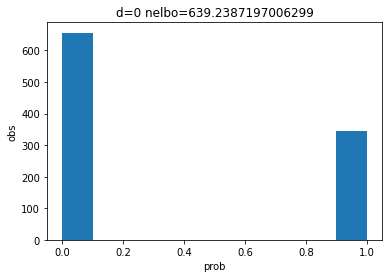

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,23672
nelbo,639.23872
entropy,-866.64691
reconstruction_loss,-1505.88563
_runtime,323
_timestamp,1630674169
_step,23671


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▁▆▆▆▆█▇▇▆▅▄▂▂▃▅▅▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
reconstruction_loss,▁▄▇▇▇▇██████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 116106.83972084188; pi: tensor([0.4384, 0.3028, 0.2588], dtype=torch.float64)
NELBO: 7581.465643535126; pi: tensor([0.1857, 0.7041, 0.1102], dtype=torch.float64)
NELBO: 3905.712358812023; pi: tensor([0.0796, 0.8730, 0.0474], dtype=torch.float64)
NELBO: 2837.4404452730423; pi: tensor([0.0398, 0.9365, 0.0238], dtype=torch.float64)
NELBO: 2500.213957578205; pi: tensor([0.0219, 0.9650, 0.0131], dtype=torch.float64)
NELBO: 2402.910876256169; pi: tensor([0.0128, 0.9796, 0.0077], dtype=torch.float64)
NELBO: 2378.5665568343593; pi: tensor([0.0077, 0.9877, 0.0046], dtype=torch.float64)
NELBO: 2371.3713834109467; pi: tensor([0.0047, 0.9924, 0.0029], dtype=torch.float64)
NELBO: 2367.6194678829606; pi: tensor([0.0029, 0.9953, 0.0018], dtype=torch.float64)
NELBO: 2365.3049757974213; pi: tensor([0.0018, 0.9970, 0.0011], dtype=torch.float64)
NELBO: 2363.8744901565815; pi: tensor([1.1582e-03, 9.9814e-01, 7.0137e-04], dtype=torch.float64)
NELBO: 2362.9830446818114; pi: tensor([7.3038e-04, 9.9883

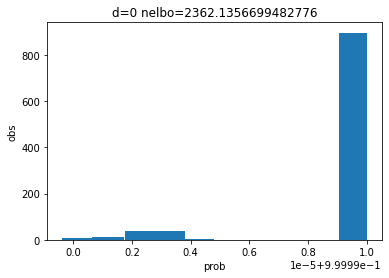

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,12768
nelbo,2362.13567
entropy,-2197.23877
reconstruction_loss,-4559.37444
_runtime,177
_timestamp,1630674351
_step,12767


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▅▆▇▇▇██████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 58107.70036751396; pi: tensor([0.2587, 0.4391, 0.3021], dtype=torch.float64)
NELBO: 7863.932269002589; pi: tensor([0.2482, 0.4620, 0.2899], dtype=torch.float64)
NELBO: 4581.601756257682; pi: tensor([0.2490, 0.4606, 0.2904], dtype=torch.float64)
NELBO: 3813.806432326951; pi: tensor([0.2498, 0.4593, 0.2909], dtype=torch.float64)
NELBO: 3597.602828194563; pi: tensor([0.2506, 0.4580, 0.2914], dtype=torch.float64)
NELBO: 3529.418168015266; pi: tensor([0.2515, 0.4567, 0.2919], dtype=torch.float64)
NELBO: 3500.766441396815; pi: tensor([0.2522, 0.4554, 0.2924], dtype=torch.float64)
NELBO: 3484.861757244652; pi: tensor([0.2530, 0.4541, 0.2929], dtype=torch.float64)
NELBO: 3475.3425958459566; pi: tensor([0.2538, 0.4528, 0.2933], dtype=torch.float64)
NELBO: 3469.446603403876; pi: tensor([0.2546, 0.4516, 0.2938], dtype=torch.float64)
NELBO: 3465.9339579173793; pi: tensor([0.2554, 0.4504, 0.2943], dtype=torch.float64)
NELBO: 3463.7134907170675; pi: tensor([0.2561, 0.4491, 0.2947], dtype=torc

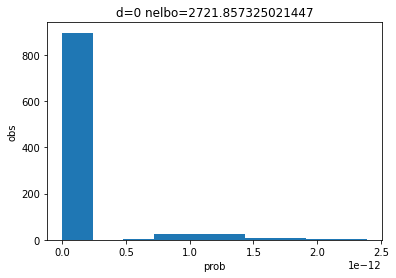

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,21365
nelbo,2721.85733
entropy,-1171.13196
reconstruction_loss,-3892.98928
_runtime,298
_timestamp,1630674653
_step,21364


ITER,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
reconstruction_loss,▁▆▇▇████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 136254.0453271327; pi: tensor([0.4384, 0.3022, 0.2594], dtype=torch.float64)
NELBO: 8770.22038658629; pi: tensor([0.1865, 0.6595, 0.1541], dtype=torch.float64)
NELBO: 5458.938131810184; pi: tensor([0.0740, 0.8629, 0.0631], dtype=torch.float64)
NELBO: 3181.495868127964; pi: tensor([0.0301, 0.9439, 0.0260], dtype=torch.float64)
NELBO: 2512.750153758352; pi: tensor([0.0142, 0.9735, 0.0123], dtype=torch.float64)
NELBO: 2409.414566311967; pi: tensor([0.0077, 0.9856, 0.0067], dtype=torch.float64)
NELBO: 2384.1185640654985; pi: tensor([0.0045, 0.9916, 0.0039], dtype=torch.float64)
NELBO: 2373.8941464183054; pi: tensor([0.0027, 0.9949, 0.0024], dtype=torch.float64)
NELBO: 2368.669062485881; pi: tensor([0.0017, 0.9968, 0.0015], dtype=torch.float64)
NELBO: 2365.76647470211; pi: tensor([1.0529e-03, 9.9803e-01, 9.2148e-04], dtype=torch.float64)
NELBO: 2364.0774844679627; pi: tensor([6.6129e-04, 9.9876e-01, 5.7920e-04], dtype=torch.float64)
NELBO: 2363.0676134863697; pi: tensor([4.1690e-04, 

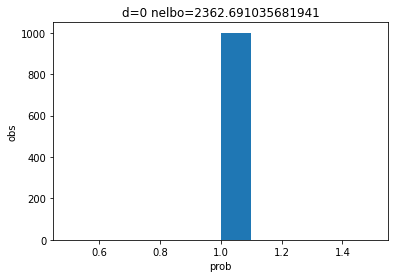

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,11544
nelbo,2362.69104
entropy,-2197.67773
reconstruction_loss,-4560.36877
_runtime,158
_timestamp,1630674815
_step,11543


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,█▇█▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,▁▅▆▆▇▇▇▇▇███████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 150630.49444369442; pi: tensor([0.3022, 0.4384, 0.2594], dtype=torch.float64)
NELBO: 8794.81117204266; pi: tensor([0.5394, 0.3517, 0.1089], dtype=torch.float64)
NELBO: 5091.996198654639; pi: tensor([0.8620, 0.0985, 0.0395], dtype=torch.float64)
NELBO: 3694.1283123390604; pi: tensor([0.9522, 0.0332, 0.0146], dtype=torch.float64)
NELBO: 2467.9507507910503; pi: tensor([0.9775, 0.0155, 0.0071], dtype=torch.float64)
NELBO: 2396.727764566922; pi: tensor([0.9877, 0.0084, 0.0039], dtype=torch.float64)
NELBO: 2377.9383035619267; pi: tensor([0.9928, 0.0049, 0.0023], dtype=torch.float64)
NELBO: 2370.4857551908754; pi: tensor([0.9956, 0.0030, 0.0014], dtype=torch.float64)
NELBO: 2366.8003385516995; pi: tensor([9.9728e-01, 1.8337e-03, 8.8364e-04], dtype=torch.float64)
NELBO: 2364.706532558145; pi: tensor([9.9830e-01, 1.1434e-03, 5.5431e-04], dtype=torch.float64)
NELBO: 2363.4617342077327; pi: tensor([9.9893e-01, 7.1749e-04, 3.4951e-04], dtype=torch.float64)
trial: 18 NELBO: 2362.735086750956

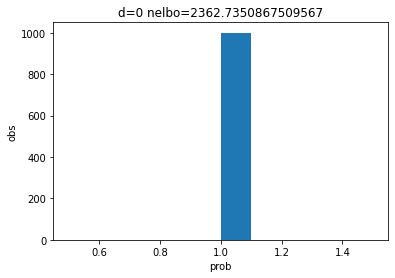

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ITER,10940
nelbo,2362.73509
entropy,-2197.44141
reconstruction_loss,-4560.17649
_runtime,152
_timestamp,1630674972
_step,10939


ITER,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
nelbo,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy,▁▁▂▄▅▆▅▅▆▇██▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
reconstruction_loss,▁▄▆▇▇▇▇█████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


NELBO: 107207.73305700601; pi: tensor([0.4391, 0.3021, 0.2587], dtype=torch.float64)
NELBO: 10698.493705761626; pi: tensor([0.4055, 0.3612, 0.2333], dtype=torch.float64)
NELBO: 5513.9229612569125; pi: tensor([0.4047, 0.3610, 0.2344], dtype=torch.float64)
NELBO: 4114.549060493493; pi: tensor([0.4039, 0.3608, 0.2353], dtype=torch.float64)
NELBO: 3666.9430789005255; pi: tensor([0.4031, 0.3606, 0.2363], dtype=torch.float64)
NELBO: 3531.225033490916; pi: tensor([0.4024, 0.3603, 0.2373], dtype=torch.float64)
NELBO: 3492.4263592874368; pi: tensor([0.4016, 0.3601, 0.2382], dtype=torch.float64)
NELBO: 3479.0071501083676; pi: tensor([0.4009, 0.3599, 0.2392], dtype=torch.float64)
NELBO: 3471.529086723587; pi: tensor([0.4001, 0.3597, 0.2402], dtype=torch.float64)
NELBO: 3466.6574193200613; pi: tensor([0.3994, 0.3595, 0.2412], dtype=torch.float64)
NELBO: 3463.1873006663227; pi: tensor([0.3986, 0.3593, 0.2421], dtype=torch.float64)
NELBO: 3436.520436887221; pi: tensor([0.3980, 0.3591, 0.2429], dtype

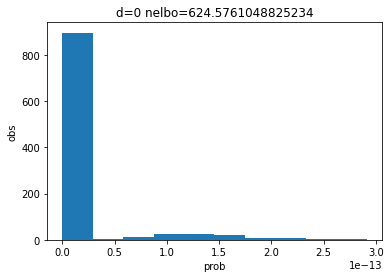

In [10]:
for trial in range(nt):
  
  Y = np.array(Y)
  S = np.array(S)
  kms = [KMeans(nc).fit(Y) for i in range(N_INIT)]
  inertias = [k.inertia_ for k in kms]
  km = kms[np.argmin(np.array(inertias))] ## selected "best" kmeans based on inertia score
  init_labels = km.labels_
  
  mu_init = np.array([Y[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
  sigma_init = np.array([Y[init_labels == i,:].std(0) for i in np.unique(init_labels)])
  psi_init = np.array([S[init_labels == i].mean() for i in np.unique(init_labels)])
  omega_init = np.array([S[init_labels == i].std() for i in np.unique(init_labels)])
  pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
  tau_init = np.ones((nc,nc))
  tau_init = tau_init / tau_init.sum()

  Theta = {
    'log_mu': np.log(mu_init) + 0.05 * np.random.randn(mu_init.shape[0], mu_init.shape[1]),
    'log_sigma': np.log(sigma_init), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init),
    'log_omega': np.log(omega_init),
    "is_delta": F.log_softmax(torch.tensor([0.95, 1-0.95])),
    'is_pi': F.log_softmax(torch.tensor(pi_init)),
    'is_tau': F.log_softmax(torch.tensor(tau_init))
  }
  Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}

  #Theta['is_delta'].requires_grad = False
  #Theta['is_pi'].requires_grad = False
  #Theta['is_tau'].requires_grad = False

  r_net = BasicForwardNet(P, nc)
  v_net = BasicForwardNet(P, nc ** 2)
  d_net = BasicForwardNet(P, 2)

  Y = torch.tensor(Y)
  S = torch.tensor(S)
  YS = torch.hstack((Y,S.reshape(-1,1))).float()

  params = list(Theta.values()) + list(r_net.parameters()) + list(v_net.parameters()) + list(d_net.parameters())
  opt = optim.AdamW(params, lr=lr)

  wandb.init(project='jett-vi',
           config={
    "N_EPOCHS": N_ITER,
    "LR": lr,
    "TOL": tol,
    'MODEL_TYPE': 'vi',
    'DATA_TYPE': 'toy_data'
  })

  loss = []
  for i in range(N_ITER):
  
    opt.zero_grad()
    r, log_r = r_net(YS)
    v, log_v = v_net(YS)
    d, log_d = d_net(YS)
  
    ## row sums to 1 (from neural net)
    log_q0 = log_d[:,0].reshape(-1,1) + log_r ## like r in em version
    log_q1 = log_d[:,1].reshape(-1,1) + log_v ## like v in em version
    
    log_rzd0, log_vgd1 = compute_joint_probs(Theta, Y, S)

    entro = (d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
    recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()

    #entro = (log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()
    #recon = (log_q0.exp() * log_rzd0).sum() + (log_q1.exp() * log_vgd1).sum()
    nelbo = entro - recon

    #nelbo = (log_q0.exp() * (log_q0 - log_rzd0)).sum() + (log_q1.exp() * (log_q1 - log_vgd1)).sum()

    nelbo.backward()
    opt.step()
  
    wandb.log({
      'ITER': i + 1, 
      'nelbo': nelbo.detach(),
      'entropy': entro.detach(),
      'reconstruction_loss': recon.detach(),
      'log_mu': Theta['log_mu'],
      'log_sigma': Theta['log_sigma'], #np.zeros_like(sigma_init),
      'log_psi': Theta['log_psi'],
      'log_omega': Theta['log_omega'],
      "is_delta": Theta['is_delta'],
      'is_pi': Theta['is_pi'],
      'is_tau': Theta['is_tau'],
      'r': r,
      'v': v,
      'd': d,
      })
  
    if i % (1000 - 1) == 0:
      #print("NELBO: {}; lambda: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_delta'].detach()).exp(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      #print("NELBO: {}; entro: {}; recon: {}; pi: {}".format(nelbo.detach(), entro.detach(), recon.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
      print("NELBO: {}; pi: {}".format(nelbo.detach(), F.log_softmax(Theta['is_pi'].detach()).exp()))
  
    if i > 0 and abs(loss[-1] - nelbo.detach()) < tol:
      break
           
    loss.append(nelbo.detach())

  print("trial: {} NELBO: {}".format(trial, nelbo.detach()))

  plt.figure()
  plt.hist(np.array(d.T[0].detach().numpy()))
  plt.title('d=0 nelbo={}'.format(nelbo.detach()))
  plt.xlabel('prob')
  plt.ylabel('obs')
  plt.show()
 

In [11]:
ddd

NameError: ignored

In [ ]:
#elbo1 = q0 * (log_rzd0 - log_q0)
  #elbo2 = q1 * (log_vgd1 - log_q1)
  #nelbo = elbo1.sum() + elbo2.sum()
  #-elbo, entro, recon

  #assert( ((d_net(YS)[0][:,1].reshape(-1,1) * v_net(YS)[0]).sum(1) + (d_net(YS)[0][:,0].reshape(-1,1) * r_net(YS)[0]).sum(1)).sum() == 1000. )
lfgh

In [ ]:
F.log_softmax(Theta['is_delta']).exp()

In [ ]:
np.exp(theta_true['log_lambda0'])

In [ ]:
F.log_softmax(Theta['is_pi']).exp()

In [ ]:
np.exp(theta_true['log_pi'])

In [ ]:
#F.log_softmax(v.mean(0).reshape(-1)).reshape(nc, nc).exp()

In [ ]:
F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc, nc).exp()

In [ ]:
np.exp(theta_true['log_tau'])

In [ ]:
Theta['log_mu'].exp()

In [ ]:
np.exp(theta_true['log_mu'])

In [ ]:
#(d * log_d).sum() + (r * log_r).sum() + (v * log_v).sum()
#(log_q0.exp() * log_q0).sum() + (log_q1.exp() * log_q1).sum()

In [ ]:
array([0.21556331, 0.36339486, 0.42104183])

In [ ]:
d.T[0]

In [ ]:
plt.hist(np.array(d.T[1].detach().numpy()))

plt.title('d=1')
plt.xlabel('prob')
plt.ylabel('obs')

In [ ]:
array([0.09716075, 0.12602853, 0.15238882, 0.2619916 , 0.36243031])

In [ ]:
ddd

In [ ]:
abs(loss[-1] - nelbo.detach())

In [ ]:
i

In [ ]:
loss[-1]

In [ ]:
nelbo.detach()

In [ ]:
lus = np.triu_indices(nc)

In [ ]:
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, random_split

part1 = int(0.7 * XX.shape[0])
part2 = int((XX.shape[0] - part1) / 2)
part3 = XX.shape[0] - part1 - part2

train, valid, test = random_split(torch.Tensor(XX), [part1, part2, part3], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train, batch_size=256, shuffle=True)
validloader = DataLoader(valid, batch_size=256, shuffle=False)
testloader = DataLoader(test, batch_size=256, shuffle=False)

In [ ]:
'''
for epoch in range(N_ITER):
  
  for j, batch_data in enumerate(trainloader):
    
    bY = torch.tensor(batch_data[:,:nf])
    bS = torch.tensor(batch_data[:,nf])
    bYS = torch.hstack((bY,bS.reshape(-1,1))).float()

    #print(bY.shape)
    #print(bS.shape)
    opt.zero_grad()

    r, log_r = r_net(bYS)
    v, log_v = v_net(bYS)
    d, log_d = d_net(bYS)
  
    loss = -ELBO(Theta, bY, bS, r, log_r, v, log_v, d, log_d)
    loss.backward()
    opt.step()
  
  if epoch % (1000 - 1) == 0:
    print(loss.detach())
    #print(F.log_softmax(d.mean(0)).exp())
    #print(F.log_softmax(Theta['is_pi']).exp())
    #print(loss.detach())
    #print(Theta['is_delta'].detach().exp())
    #print(Theta['is_pi'].detach().exp())
'''

In [ ]:
F.log_softmax(Theta['is_delta']).exp()

In [ ]:
F.log_softmax(Theta['is_pi']).exp()

In [ ]:
F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc, nc).exp()